In [1]:
import os
import time
import numpy as np
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from numba import njit, jit

CPU_COUNT = os.cpu_count()
print("CPU_COUNT", CPU_COUNT)

%load_ext watermark
%watermark
print()
%watermark -p numpy,numba

def PE(pool, func, args):
    with pool(max_workers=CPU_COUNT) as exc:
        fut = {exc.submit(func, *arg): i for i, arg in enumerate(args)}
        for f in as_completed(fut):
            f.result()

CPU_COUNT 8
2019-07-07T18:56:33-04:00

CPython 3.6.8
IPython 7.6.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit

numpy 1.16.4
numba 0.44.1


In [3]:
def render_hist_good(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for j in range(10):
        for i in range(len(coords)):
            y0 = coords[i, 0] * mag
            x0 = coords[i, 1] * mag
            y1 = int(y0)
            x1 = int(x0)
            m = 1
            img[y1, x1] += m

    return img

jit_render_hist_good = jit(render_hist_good, nogil=True, nopython=True)

args = [(i, 100) for i in np.random.rand(CPU_COUNT, 10000000, 2)]

%timeit jit_render_hist_good(*args[0])

print("Linear time:")
%timeit [jit_render_hist_good(*a) for a in args]

print()
print("Threads time:")
%timeit  PE(ThreadPoolExecutor, jit_render_hist_good, args)

2.14 s ± 75.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Linear time:
17.9 s ± 463 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Threads time:
5.48 s ± 213 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
def render_hist_bad(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for i in range(len(coords)):
        y0, x0 = coords[i] * mag
        y1 = int(y0)
        x1 = int(x0)
        m = 1
        img[y1, x1] += m

    return img

jit_render_hist_bad = jit(render_hist_bad, nogil=True, nopython=True)

args = [(np.random.rand(1000000, 2), 100) for i in range(CPU_COUNT)]

%timeit jit_render_hist_bad(*args[0])

print("Linear time:")
%timeit [jit_render_hist_bad(*a) for a in args]

print()
print("Threads time:")
%timeit PE(ThreadPoolExecutor, jit_render_hist_bad, args)


139 ms ± 3.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Linear time:
1.11 s ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Threads time:
1.05 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Real function

In [4]:
def render(params, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    
    radius = 3
    
    for i in range(len(params)):
        y0 = params[i, 0] * mag
        x0 = params[i, 1] * mag
        sy = params[i, 2] * mag
        sx = params[i, 3] * mag
        
        # calculate the render window size
        wy = int(sy * radius * 2.0)
        wx = int(sx * radius * 2.0)
        
        # calculate the area in the image
        ystart = int(np.rint(y0)) - wy // 2
        yend = ystart + wy
        xstart = int(np.rint(x0)) - wx // 2
        xend = xstart + wx
        
        # adjust coordinates to window coordinates
        y1 = y0 - ystart
        x1 = x0 - xstart
        
        y = np.arange(wy)
        x = np.arange(wx)
        amp = 1 / (2 * np.pi * sy * sx)
        gy = np.exp(-((y - y0) / sy) ** 2 / 2)
        gx = np.exp(-((x - x0) / sx) ** 2 / 2)
        g = amp * np.outer(gy, gx)

jit_render = jit(render, nopython=True, nogil=True)

args = [(np.random.rand(1000000, 4) * (1, 1, 0.02, 0.02), 100) for i in range(CPU_COUNT)]

print("Single time:")
# %timeit render(*args[0])
%timeit jit_render(*args[0])

print()
print("Linear time:")
%time [jit_render(*a) for a in args]

print()
print("Threads time:")
%time PE(ThreadPoolExecutor, jit_render, args)

Single time:
1.5 s ± 59.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Linear time:
CPU times: user 11.8 s, sys: 36.5 ms, total: 11.9 s
Wall time: 11.9 s

Threads time:
CPU times: user 47.3 s, sys: 59.2 ms, total: 47.4 s
Wall time: 6.1 s


In [11]:
def render(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for i in range(len(coords)):
        y0 = coords[i, 0] * mag
        x0 = coords[i, 1] * mag
        y1 = int(y0)
        x1 = int(x0)
        m = np.random.randn(10)
        img[y1, x1] += m[0]

    return img

jit_render = jit(render, nopython=True, nogil=True)

print("Single time:")
# %timeit render(*args[0])
%timeit jit_render(*args[0])

print()
print("Linear time:")
%time [jit_render(*a) for a in args]

print()
print("Threads time:")
%time PE(ThreadPoolExecutor, jit_render, args)

Single time:
348 ms ± 9.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Linear time:
CPU times: user 2.85 s, sys: 3.94 ms, total: 2.85 s
Wall time: 2.86 s

Threads time:
CPU times: user 8.13 s, sys: 35.2 ms, total: 8.16 s
Wall time: 1.11 s


In [113]:
def render(yx_shape, params, mag, multipliers, diffraction_limit):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    
    radius = 3
    
    ymax = int(yx_shape[0] * mag)
    xmax = int(yx_shape[1] * mag)
    img = np.zeros((ymax, xmax))
    for i in range(len(params)):
        if not np.isfinite(params[i]).all():
            # skip nans
            continue
        y0 = params[i, 0] * mag
        x0 = params[i, 1] * mag
        sy = params[i, 2] * mag
        sx = params[i, 3] * mag
        
        # adjust parameters if diffraction limit is requested
        if diffraction_limit:
            sy = max(sy, 0.5)
            sx = max(sx, 0.5)
        
        # calculate the render window size
        wy = int(sy * radius * 2.0)
        wx = int(sx * radius * 2.0)
        
        # calculate the area in the image
        ystart = int(np.rint(y0)) - wy // 2
        yend = ystart + wy
        xstart = int(np.rint(x0)) - wx // 2
        xend = xstart + wx
        
        # don't go over the edge
        yend = min(yend, ymax)
        ystart = max(ystart, 0)
        xend = min(xend, xmax)
        xstart = max(xstart, 0)
        wy = yend - ystart
        wx = xend - xstart
        if wy == 0 or wx == 0:
            continue
        
        # adjust coordinates to window coordinates
        y1 = y0 - ystart
        x1 = x0 - xstart
        
        y = np.arange(wy)#.reshape(-1, 1)
        x = np.arange(wx)#.reshape(1, -1)
        amp = 1 / (2 * np.pi * sy * sx)
        gy = np.exp(-((y - y0) / sy) ** 2 / 2)
        gx = np.exp(-((x - x0) / sx) ** 2 / 2)
#         # below are all problem lines that lead to a severe slowdown ...
#         g = amp * gy * gx
#         g = _jit_gauss(wy, wx, y1, x1, sy, sx)
        
#         # weight if requested
#         if len(multipliers):
#             g *= multipliers[i]
        
#         img[ystart:yend, xstart:xend] += g
#         img[ystart, xstart] += g[0, 0]
#         y2 = int(y0)
#         x2 = int(x0)
#         for j in range(10000):
#             img[y2, x2] += 1
    return img

jit_render = jit(render, nopython=True, nogil=True)

args = [((1, 1), np.random.rand(200000, 4), 100, np.random.rand(100000), True) for i in range(CPU_COUNT)]

%timeit jit_render(*args[0])

# print("Linear time:")
# %time linear_compute = [jit_render(*a) for a in args]

delayed_jit_render = dask.delayed(jit_render)
# delayed_jit_render = dask.delayed(jit_render)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render(*a) for a in args], scheduler="threads")


678 ms ± 39.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Threads time:
Wall time: 11.2 s


In [27]:
_jit_gauss(10, 50, 5, 20, 4, 5).shape

(10, 50)

# Actual func

In [ ]:
from pyPALM.render import _jit_gen_img_sub as render
old_render = render
from pyPALM.render import _jit_gauss, _gen_img_sub

In [7]:
jit_render = jit(_gen_img_sub, nopython=True, nogil=True)

size = 8
mag = 100
npts = 100000

args = [(np.array((size, size)), np.random.rand(npts, 4) * (size, size, 0.25, 0.25), mag, np.random.rand(npts), True) for i in range(CPU_COUNT)]

%timeit jit_render(*args[0])

print("Linear time:")
%time linear_compute = [jit_render(*a) for a in args]

delayed_jit_render = dask.delayed(jit_render)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render(*a) for a in args], scheduler="threads")

# print()
# print("Processes time:")
# %time dask_compute_threads = dask.compute(*[delayed_jit_render(*a) for a in args], scheduler="processes")
dask_compute_threads[0].shape

3.38 s ± 65.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Linear time:
Wall time: 2min 45s

Threads time:
Wall time: 1min 8s


(800, 800)

In [8]:
jit_render = jit(_gen_img_sub, nopython=True, nogil=True)

size = 800
mag = 1
npts = 100000

args = [(np.array((size, size)), np.random.rand(npts, 4) * (size, size, 0.25, 0.25), mag, np.random.rand(npts), True) for i in range(CPU_COUNT)]

%timeit jit_render(*args[0])

print("Linear time:")
%time linear_compute = [jit_render(*a) for a in args]

delayed_jit_render = dask.delayed(jit_render)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render(*a) for a in args], scheduler="threads")

# print()
# print("Processes time:")
# %time dask_compute_threads = dask.compute(*[delayed_jit_render(*a) for a in args], scheduler="processes")
dask_compute_threads[0].shape

150 ms ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Linear time:
Wall time: 8.4 s

Threads time:
Wall time: 8.68 s


(800, 800)

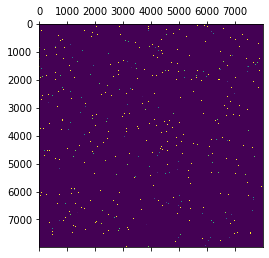

In [10]:
plt.matshow(dask_compute_threads[0], norm=mpl.colors.PowerNorm(0.5), vmax=0.001)

In [34]:
dask_compute_threads[0].shape

(8000, 8000)

In [17]:
np.random.rand(10, 10)[(slice(2), slice(3))].shape

(2, 3)